# CPSC 330 Lecture 15

### Lecture plan

Feature engineering, embeddings, sparse matrices


- T/F questions (15 min)
- ~~Intro to NLP (5 min)~~
- ~~Word counts, TF-IDF (10 min)~~
- Break (5 min)
- Sparse matrices in Python (10 min)
- ~~Preprocessing (15 min)~~
- Word embeddings (15 min)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.sparse

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import string 
import re
from collections import defaultdict
from collections import Counter

In [2]:
plt.rcParams['font.size'] = 16

New dependency: `nltk`. Install with

`pip install nltk`

or

`conda install nltk`

You may need to install some "nltk data" afterwards. If so, nltk itself will give you instruction for doing so.

In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

New dependency: `gensim`. Install with:

`pip install gensim`

or 

`conda install -c conda-forge gensim`

In [4]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors, FastText

## True/False questions (15 min)

- Removing features generally decreases your training score.
- Removing features generally increases your validation score.
- Removing a feature can change the feature importances of other features, including the _order_ of those importances.
- sklearn's `Lasso` selects features but does not make predictions.

<br><br><br><br><br><br>

## Intro to NLP (5 min)

- Natural Language Processing (NLP) involves extracting information from human language.
- There are many possible NLP tasks for many purposes. Here are just a few examples:
  - translation
  - summarization
  - sentiment analysis
  - relationship extraction
  - question answering / chatbots
- NLP is very difficult! Some examples:

Example: Lexical ambiguity


<img src="img/lexical_ambiguity.png" width="800" height="800">

Example: Part-of-speech ambiguity

<center><img src="img/pos_ambiguity.png" width="800" height="800"></center>

Example: Referential ambiguity


<img src="img/referential_ambiguity.png" width="800" height="800">

- In short, you could do an entire course (or an [entire degree](https://masterdatascience.ubc.ca/programs/computational-linguistics)!) on NLP.
- In this class we'll focus on **turning text into numeric features**.
- We'll use the [IMDB movie review dataset](https://www.kaggle.com/utathya/imdb-review-dataset) from Kaggle, also used in Lecture 5.

In [5]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))].drop(columns=['file', 'type'])
df_train, df_test = train_test_split(imdb_df, random_state=123)
df_train.head()

,review,label
6105,This movie was a dismal attempt at recreating ...,neg
9940,"These days, Ridley Scott is one of the top dir...",neg
45421,on the contrary to the person listed above me ...,pos
42236,This is one of those movies that you wish you ...,pos
15382,It's hard for me to explain this show to my gr...,pos


In [6]:
df_train.iloc[1]["review"]

"These days, Ridley Scott is one of the top directors and producers and can command huge sums to helm movies--especially since he has films like ALIEN, GLADIATOR and BLADE RUNNER to his credit. So from this partial list of his credits, it's obvious he's an amazing talent. However, if you watch this very early effort that he made while in film school, you'd probably have a hard time telling that he was destined for greatness. That's because although it has some nice camera-work and style, the film is hopelessly dull and uninvolving. However, considering that it wasn't meant for general release and it was only a training ground, then I am disposed to looking at it charitably--hence the score of 4.<br /><br />By the way, this film is part of the CINEMA 16: European Shorts DVD. On this DVD are 16 shorts. Most aren't great, though because it contains THE MAN WITHOUT A HEAD, COPY SHOP, RABBIT and WASP, it's an amazing DVD for lovers of short films and well worth buying."

### Text data

- How do we feed it into ML algorithms?
- How do we represent the meaning of text?

## Word counts and TF-IDF (10 min)

We've seen `CountVectorizer` in Lecture 5:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
countvec = CountVectorizer()

In [9]:
countvec.fit(df_train["review"]);

In [10]:
X_train_counts = countvec.transform(df_train["review"])

Let's look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

(Note: `??` or shift-tab in Jupyter)

In [12]:
??CountVectorizer.fit

Signature: CountVectorizer.fit(self, raw_documents, y=None)
Source:   
    def fit(self, raw_documents, y=None):
        """Learn a vocabulary dictionary of all tokens in the raw documents.

        Parameters
        ----------
        raw_documents : iterable
            An iterable which yields either str, unicode or file objects.

        Returns
        -------
        self
        """
        self._warn_for_unused_params()
        self.fit_transform(raw_documents)
        return self
File:      ~/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py
Type:      function


In [13]:
X_train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

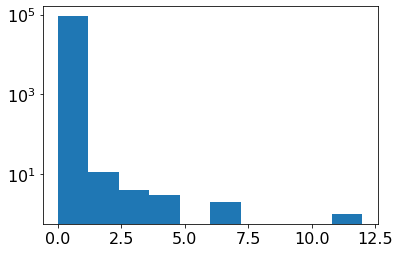

In [14]:
plt.hist(X_train_counts[0].toarray().flatten(), log=True);

- In a few minutes we'll talk about many of these hyperparameters.
- The ones that most simply control the number of features are `max_features`, `min_df`, and `max_df`.

In [15]:
X_train_counts.shape

(37500, 91308)

In [15]:
CountVectorizer(min_df=5).fit_transform(df_train["review"]).shape

(37500, 32743)

In [16]:
CountVectorizer(min_df=5, max_df=100).fit_transform(df_train["review"]).shape

(37500, 27650)

In [17]:
CountVectorizer(min_df=5, max_df=100, max_features=1000).fit_transform(df_train["review"]).shape

(37500, 1000)

In [18]:
CountVectorizer(vocabulary=["good", "bad", "silly", "horrible"]).fit_transform(df_train["review"]).shape

(37500, 4)

#### Term Frequency - Inverse Document Frequency (TF-IDF)

- Intuition: normalize word count by the frequency of the word in the entire dataset.
- If "earthshattering" appears 10 times, that is more meaningful than if "movie" appears 10 times.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

The shape is the same as what we get from `CountVectorizer`, but the counts are normalized - we won't go into the details.

In [20]:
X_train_tfidf = TfidfVectorizer(max_features=1000).fit_transform(df_train["review"])
X_train_tfidf.shape

(37500, 1000)

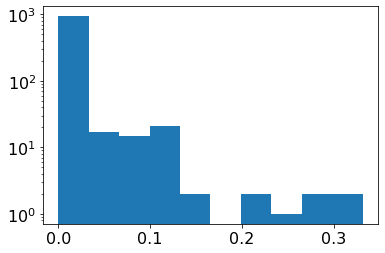

In [21]:
plt.hist(X_train_tfidf[0].toarray().flatten(), log=True);

Let's look at a very simple case:

In [18]:
corpus = [
            "This is the first document, the FIRST",
            "This is the second document",
            "This is the third document",
            "This is the fourth document"
         ]

In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df

,document,first,fourth,is,second,the,third,this
D1,1,2,0,1,0,2,0,1
D2,1,0,0,1,1,1,0,1
D3,1,0,0,1,0,1,1,1
D4,1,0,1,1,0,1,0,1


In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df

,document,first,fourth,is,second,the,third,this
D1,0.214725,0.822953,0.000000,0.214725,0.000000,0.429451,0.000000,0.214725
D2,0.361028,0.000000,0.000000,0.361028,0.691835,0.361028,0.000000,0.361028
D3,0.361028,0.000000,0.000000,0.361028,0.000000,0.361028,0.691835,0.361028
D4,0.361028,0.000000,0.691835,0.361028,0.000000,0.361028,0.000000,0.361028


Note: there is also [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) which takes the word counts from `CountVectorizer` and transforms them. The output should be the same as if you used `TfidfVectorizer`.

## Sparse matrices in Python (10 min)

We had this code earlier:

In [21]:
X_train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Why did we need `.toarray()`?

In [26]:
type(X_train_counts)

scipy.sparse.csr.csr_matrix

This is a **sparse matrix**. Why? Look at the shape:

In [22]:
X_train_counts.shape

(37500, 91308)

How many elements total?

In [28]:
np.prod(X_train_counts.shape)

3424050000

A lot! How many are nonzero though?

In [29]:
X_train_counts.nnz

5114043

In [30]:
frac_nz = X_train_counts.nnz / np.prod(X_train_counts.shape)
frac_nz

0.0014935655145222762

- This happens because most words do not appear in a given document. 
- We get massive computational savings if we **only store the nonzero elements**. 
- There is a bit of overhead, because we also need to **store the locations**:
  - e.g. "location (5,192): 3".
  - However, if the fraction of nonzero is small, this is a huge win.

Here are the nonzero elements in the first review:

In [31]:
print(X_train_counts[0])

  (0, 1893)	1
  (0, 1894)	1
  (0, 4036)	2
  (0, 4378)	1
  (0, 5338)	1
  (0, 5509)	1
  (0, 5868)	2
  (0, 6013)	1
  (0, 7736)	2
  (0, 7843)	1
  (0, 8109)	1
  (0, 8806)	1
  (0, 10625)	1
  (0, 10826)	6
  (0, 12242)	2
  (0, 13705)	1
  (0, 14076)	1
  (0, 15561)	1
  (0, 18502)	1
  (0, 19264)	3
  (0, 19379)	1
  (0, 20503)	1
  (0, 20762)	1
  (0, 21067)	1
  (0, 22422)	2
  :	:
  (0, 63802)	2
  (0, 66090)	1
  (0, 66751)	1
  (0, 66890)	1
  (0, 67724)	1
  (0, 69096)	1
  (0, 70346)	1
  (0, 73319)	1
  (0, 74862)	1
  (0, 76703)	1
  (0, 80828)	1
  (0, 80846)	12
  (0, 81118)	4
  (0, 81556)	1
  (0, 81794)	2
  (0, 83065)	1
  (0, 83651)	1
  (0, 86703)	1
  (0, 86710)	1
  (0, 87889)	3
  (0, 88008)	7
  (0, 88172)	3
  (0, 88502)	2
  (0, 88885)	1
  (0, 89196)	1


- BTW, have you noticed that with `OneHotEncoder` we've been setting `sparse=False`. 
- This is to get it to return a regular numpy array instead of a sparse array, so we didn't have to deal with these.
- If there are a huge number of categories, it may be beneficial to keep them as sparse.
- For smaller number of categories, it doesn't matter much.

#### Working with scipy.sparse matrices

- We won't go into implementation details here, but there are some "gotchas" with `scipy.sparse`.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [24]:
x = np.random.rand(10, 10)

In [33]:
x[1, 2]

0.19861089003333154

In [34]:
x[1][2]

0.19861089003333154

In [35]:
(x[1])[2]

0.19861089003333154

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [36]:
x[1]

array([0.65399277, 0.84521827, 0.19861089, 0.00167515, 0.64181605,
       0.25209052, 0.01963685, 0.51772779, 0.19828813, 0.44265865])

In [37]:
row_1 = x[1]
row_1[2]

0.19861089003333154

However, with `scipy.sparse` matrices, things are a bit different:

In [25]:
x_sparse = scipy.sparse.csr_matrix(x)

In [26]:
x_sparse[1, 2]

0.18289061542864404

In [27]:
x_sparse[1][2]

IndexError: row index (2) out of range

Why?

In [28]:
row_1_sparse = x_sparse[1]

In [42]:
row_1_sparse.shape

(1, 10)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [43]:
lst = [[1, 2, 3], [4, 5, 6], [7, 9]]
lst

[[1, 2, 3], [4, 5, 6], [7, 9]]

In [44]:
lst[0][1]

2

In [45]:
lst[0, 1]

TypeError: list indices must be integers or slices, not tuple

#### sparse matrix operations

Let's try to find the highest word count. But first, review the `axis` keyword:

In [46]:
x = np.random.randint(10, size=(4,5))
x

array([[9, 4, 8, 0, 0],
       [6, 2, 5, 9, 7],
       [1, 2, 3, 4, 0],
       [0, 1, 6, 3, 6]])

In [47]:
np.sum(x)

76

In [48]:
np.sum(x, axis=0)

array([16,  9, 22, 16, 13])

In [49]:
np.sum(x, axis=1)

array([21, 29, 10, 16])

Back to our word counts:

In [50]:
X_train_counts.max()

198

The max for each document:

In [51]:
X_train_counts.max(axis=1)

<37500x1 sparse matrix of type '<class 'numpy.int64'>'
	with 37500 stored elements in COOrdinate format>

The document with the highest word count:

In [52]:
np.argmax(X_train_counts.max(axis=1))

26017

- Regular numpy functions work on sparse matrices, although they might be fast/slow depending. 
- You definitely do not want to iterate with loops - make sure you use builtin functions. 
- There are some details here, in that a sparse matrix max be stored row-by-row or column-by-column, and this affects speed.
  - This is beyond the scope of the course, but something to look into if your code is too slow.

## Break (5 min)

## Preprocessing (15 min)

- Back to the various hyperparameters of `CountVectorizer`, such as:
  - `strip_accents=None`
  - `lowercase=True`
  - `preprocessor=None`
  - `tokenizer=None`
  - `stop_words=None`
  - `token_pattern='(?u)\b\w\w+\b'`
  - `ngram_range=(1, 1)`
  - `analyzer='word'`
- What do these all mean?
- They have to do with how the text is **preprocessed** before the words are counted.

#### Why preprocessing?

- We need to split things apart:
    - Segment sentences
    - Tokenize words
- We want equivalent things to match with each other
    * USA &rarr; U.S.A.
    * You're &rarr; you are
    * Hello &rarr; hello
    * Vancouver's &rarr; Vancouver
    * computers &rarr; computer 
    * rising &rarr; rise, rose, rises
- We might want to get rid of commonly occurring words
    * to, for, the, a, an, of, ...


#### Usual preprocessing pipeline

- Preprocessing is task dependent but given raw text data the usual pipeline is :
    - Sentence segmentation
    - Tokenization 
    - Stopword removal
    - Stemming or lemmatization (in some cases)

#### Tools for preprocessing 

- Many available tools
- spaCy is a good one to know about
- We will be using [Natural Language Processing Toolkit (nltk)](https://www.nltk.org/)
    - Platform to build NLP programs with Python
    - Provides access to a number of NLP preprocessing tools 

#### Sentence segmentation (finding sentence boundaries)

- ! and ? are relatively ambiguous.
- Period (.) is quite ambiguous.
    - Sentence boundary?
    - Abbreviations like Dr., U.S., Inc.  
    - Numbers like 60.44%, 0.98
- Build a binary classifier to decide whether a period is a sentence boundary marker or not.

In [29]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [54]:
review = df_train.iloc[1]["review"].replace("<br />", "\n")
print(review)

These days, Ridley Scott is one of the top directors and producers and can command huge sums to helm movies--especially since he has films like ALIEN, GLADIATOR and BLADE RUNNER to his credit. So from this partial list of his credits, it's obvious he's an amazing talent. However, if you watch this very early effort that he made while in film school, you'd probably have a hard time telling that he was destined for greatness. That's because although it has some nice camera-work and style, the film is hopelessly dull and uninvolving. However, considering that it wasn't meant for general release and it was only a training ground, then I am disposed to looking at it charitably--hence the score of 4.

By the way, this film is part of the CINEMA 16: European Shorts DVD. On this DVD are 16 shorts. Most aren't great, though because it contains THE MAN WITHOUT A HEAD, COPY SHOP, RABBIT and WASP, it's an amazing DVD for lovers of short films and well worth buying.


In [55]:
review_sentences = sent_tokenize(review)
review_sentences

['These days, Ridley Scott is one of the top directors and producers and can command huge sums to helm movies--especially since he has films like ALIEN, GLADIATOR and BLADE RUNNER to his credit.',
 "So from this partial list of his credits, it's obvious he's an amazing talent.",
 "However, if you watch this very early effort that he made while in film school, you'd probably have a hard time telling that he was destined for greatness.",
 "That's because although it has some nice camera-work and style, the film is hopelessly dull and uninvolving.",
 "However, considering that it wasn't meant for general release and it was only a training ground, then I am disposed to looking at it charitably--hence the score of 4.",
 'By the way, this film is part of the CINEMA 16: European Shorts DVD.',
 'On this DVD are 16 shorts.',
 "Most aren't great, though because it contains THE MAN WITHOUT A HEAD, COPY SHOP, RABBIT and WASP, it's an amazing DVD for lovers of short films and well worth buying."]

#### Tokenization (finding word boundaries)

- Is presence of whitespace is not a sufficient condition for a word boundary? 
- Should we split on the special characters then? 
    - What about words like _grown-ups_ then?
- This process of identifying word boundaries is referred to as **tokenization**.
- It is not as simple and is done by training ML models.
- It gets even messier in other languages like Chinese (no spaces) and German (very long words).
    * rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz 
    * (the law for the delegation of monitoring beef labeling)
- We can use `nltk.word_tokenize`. 

In [56]:
review[:100]

'These days, Ridley Scott is one of the top directors and producers and can command huge sums to helm'

In [57]:
nltk.word_tokenize(review)[:20]

['These',
 'days',
 ',',
 'Ridley',
 'Scott',
 'is',
 'one',
 'of',
 'the',
 'top',
 'directors',
 'and',
 'producers',
 'and',
 'can',
 'command',
 'huge',
 'sums',
 'to',
 'helm']

#### Punctuation and stoplist

- The most frequently occurring words are actually the most frequently occurring words in English
    - Example: _the_, _is_, _a_, and punctuation
- Probably not very informative for certain tasks 
    - Let's use `nltk.stopwords`.  
    - Add punctuations to the list. 

In [58]:
stop_words = list(set(stopwords.words('english')))
stop_words += list(string.punctuation)
print(', '.join(stop_words))

needn't, nor, them, than, aren, during, you've, she's, being, yours, had, wouldn't, each, about, where, an, they, him, before, couldn't, don't, me, which, himself, doing, or, out, o, herself, did, that, under, there, whom, into, was, have, mightn't, ve, as, again, having, ma, you, weren, while, you'll, wouldn, but, in, you're, who, didn, she, has, her, shan't, wasn, you'd, after, from, down, he, yourselves, shouldn, any, theirs, until, hasn, haven, how, will, just, other, because, this, why, aren't, for, been, hasn't, haven't, mightn, such, ours, further, that'll, re, themselves, now, all, do, to, ll, am, own, over, hadn't, when, my, it's, a, up, doesn't, should've, on, won't, can, more, s, y, not, don, shan, of, mustn, shouldn't, their, above, it, does, hadn, were, then, we, some, our, too, won, yourself, between, wasn't, at, very, these, are, isn't, those, same, couldn, needn, t, your, here, and, off, didn't, is, hers, m, if, his, what, ain, by, once, few, myself, through, both, so, 

This can be set with the `stop_words` parameter with `CountVectorizer`.

#### Stemming

- Stemming is a crude chopping of affixes 
    * _automates, automatic, automation_ all reduced to _automat_.
- Beware that it can be aggressive sometimes.
- This is something `CountVectorizer` does **not** do:

In [59]:
vocab = list(countvec.vocabulary_.keys())

In [60]:
{v for v in vocab if v.startswith('wait')}

{'wait',
 'waite',
 'waited',
 'waiter',
 'waiters',
 'waites',
 'waiting',
 'waitress',
 'waitresses',
 'waitressing',
 'waits',
 'waitâ'}

- Let's try stemming before finding the most frequently occurring words. 

In [61]:
from nltk.stem.porter import PorterStemmer

In [62]:
ps = PorterStemmer()

vocab_stemmed = [ps.stem(v) for v in vocab]

In [63]:
{v for v in vocab_stemmed if v.startswith('wait')}

{'wait', 'waiter', 'waitress', 'waitâ'}

#### Lemmatization

- In some tasks, it makes sense to reduce all forms of a word to its base form (e.g., *lemma* or *stem*)
    * am, are, is &rarr; be
    * went, going, goes, gone &rarr; go
    * We can address this by using [nltk.stem.wordnet](https://www.nltk.org/_modules/nltk/stem/wordnet.html). 

In [64]:
from nltk.stem import WordNetLemmatizer

In [65]:
# import nltk
# nltk.download('wordnet')

In [66]:
wnl = WordNetLemmatizer()
verbs = ['went', 'being', 'gone']
nouns = ['wolves', 'assessment']
for word in verbs: 
    print('%s --> %s' %(word, wnl.lemmatize(word,'v')))

went --> go
being --> be
gone --> go


#### $n$-grams 

- A contiguous sequence of _n_ items (characters, tokens) in text
- bigrams: a contiguous sequence of two items
- trigrams: a contiguous sequence of three items

In [32]:
countvec_bigram = CountVectorizer(ngram_range=(1,2), max_features=1000)
countvec_bigram.fit(df_train[:1000]["review"]);

In [34]:
countvec_bigram.vocabulary_

{'this': 826,
 'movie': 516,
 'was': 914,
 'attempt': 79,
 'at': 75,
 'time': 840,
 'in': 384,
 'english': 226,
 'history': 361,
 'the': 763,
 'film': 268,
 'version': 897,
 'of': 555,
 'war': 913,
 'is': 402,
 'but': 128,
 'overall': 595,
 'way': 926,
 'off': 570,
 'that': 753,
 'started': 726,
 'over': 593,
 'no': 542,
 'both': 114,
 'were': 934,
 'never': 537,
 'did': 190,
 'he': 346,
 'ever': 241,
 'save': 655,
 'day': 182,
 'not': 545,
 'br': 117,
 'as': 69,
 'another': 57,
 'has': 338,
 'certainly': 149,
 'one': 579,
 'who': 949,
 'to': 843,
 'be': 88,
 'from': 297,
 'house': 370,
 'and': 37,
 'decent': 186,
 'hard': 336,
 'it': 417,
 'didn': 192,
 'turn': 877,
 'out': 590,
 'so': 707,
 'great': 323,
 'definitely': 187,
 'could': 170,
 'have': 341,
 'been': 95,
 'better': 103,
 'this movie': 829,
 'movie was': 522,
 'the film': 777,
 'version of': 898,
 'in the': 391,
 'but the': 133,
 'of this': 567,
 'this film': 827,
 'that the': 757,
 'at the': 78,
 'did not': 191,
 'br br': 

In [30]:
# vocab_df = pd.DataFrame(data=countvec_bigram.vocabulary_.values(), index=countvec_bigram.vocabulary_.keys(), columns = ['frequency'])
# vocab_df

#### Aside: Google n-gram viewer

[Google n-gram viewer](https://books.google.com/ngrams)

<img src="img/google_ngram_viewer.png" width="800" height="800">


## Word embeddings (15 min)

- Word embeddings: "embed" a word in a vector space.
- You have a bunch of feature columns, each word has a representation.

#### Vector space model

- Model the meaning of a word by placing it into a vector space.  
- Distances among words in the vector space indicate the relationship between them. 

<img src="img/t-SNE_word_embeddings.png" width="700" height="700">

(Attribution: Jurafsky and Martin 3rd edition)

#### Distributional hypothesis

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

<blockquote> 
If A and B have almost identical environments we say that they are synonyms.
<footer>Harris, 1954</footer>    
</blockquote>    

Example: 

- Her **child** loves to play in the playground. 
- Her **kid** loves to play in the playground. 



#### Co-occurrence matrices
- A way to represent vectors into a vector space

#### Term-document matrix

- This like the transpose of `CountVectorizer`.
- Each cell is a count of words in the document in that column. 
- You can describe a document in terms of the frequencies of different words in it. 
- You can describe a word in terms of its frequency in different documents. 

In [71]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4', 'D5']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df.transpose()

,D1,D2,D3,D4,D5
apricot,0,0,1,0,0
big,1,0,1,0,1
data,1,0,0,1,1
information,1,0,0,1,1
sugar,0,1,0,0,0
walnut,0,1,0,0,0


### Term-term matrix

- The idea is to go through a corpus of text, keeping a count of all of the words that appear in its context within a window.

In [35]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']
vec = CountVectorizer(ngram_range=(1,1)) 
X = vec.fit_transform(corpus)
X_ww = X.T@X
X_ww.setdiag(0) 
header = vec.get_feature_names()
ind_col = header
df = pd.DataFrame(X_ww.toarray(), columns = header, index = ind_col)  
df

,apricot,big,data,information,sugar,walnut
apricot,0,1,0,0,0,0
big,1,0,2,2,0,0
data,0,2,0,3,0,0
information,0,2,3,0,0,0
sugar,0,0,0,0,0,1
walnut,0,0,0,0,1,0


In [74]:
df_subset = df[['big','data']]
df_subset.iloc[2:]

,big,data
data,2,0
information,2,3
sugar,0,0
walnut,0,0


#### Sparse vs. dense word vectors

- Term-term and term-document matrices are sparse. 
- OK because there are efficient ways to deal with sparse matrices.


#### Alternative 
- Learn short (~100 to 1000 dimensions) and dense vectors. 
- These short dense representations of words are referred to as **word embeddings**.
- Short vectors may be easier to train with ML models (less weights to train).
- They may generalize better.

### How can we get dense vectors?
 
- Count-based methods
    - Singular Value Decomposition (SVD) - beyond the scope of the course
- Prediction-based methods
    - [Word2Vec](https://github.com/tmikolov/word2vec)
    - [fastText](https://fasttext.cc/)
    - [GloVe](https://nlp.stanford.edu/projects/glove/)

### Word2Vec

<img src="img/word2vec.png" width="700" height="700">


#### Success of Word2Vec

- Able to capture complex relationships between words.
- Example: What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<img src="img/word_analogies1.png" width="500" height="500">

(Credit: Mikolov et al. 2013)    


#### Pre-trained embeddings

- These embeddings come from training complicated ML models on big data sets.
- However, we can skip this step and use **pre-trained** embeddings.
- Someone already did `fit` for us and published the results, we can download and just use `transform`.

A number of pre-trained word embeddings are available. The most popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook

Load Google's pre-trained Word2Vec model:

- Requires download a 1.5 GB file [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)

In [69]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [70]:
print('Size of vocabulary: ', len(model.vocab))

Size of vocabulary:  3000000


In [76]:
word_pairs = [('pineapple','mango'), ('pineapple','juice'), ('sun','robot')]
for pair in word_pairs: 
    print('The similarity between %s and %s is %0.3f' %(pair[0], pair[1], model.similarity(pair[0], pair[1])))

The similarity between pineapple and mango is 0.668
The similarity between pineapple and juice is 0.418
The similarity between sun and robot is 0.029


### Finding similar words
Given word $w$, search in the vector space for the word closest to $w$:

In [ ]:
# model.most_similar('mango')

In [126]:
model.most_similar('UBC')

[('UVic', 0.7886475324630737),
 ('SFU', 0.7588527798652649),
 ('Simon_Fraser', 0.7356574535369873),
 ('UFV', 0.6880435943603516),
 ('VIU', 0.6778583526611328),
 ('Kwantlen', 0.677142858505249),
 ('UBCO', 0.6734487414360046),
 ('UPEI', 0.6731126308441162),
 ('UBC_Okanagan', 0.6709134578704834),
 ('Lakehead_University', 0.6622507572174072)]

In [112]:
model.most_similar('information')

[('info', 0.7363681793212891),
 ('infomation', 0.6800296306610107),
 ('infor_mation', 0.6733849048614502),
 ('informaiton', 0.6639008522033691),
 ('informa_tion', 0.660125732421875),
 ('informationon', 0.633933424949646),
 ('informationabout', 0.6320979595184326),
 ('Information', 0.6186580061912537),
 ('informaion', 0.6093292236328125),
 ('details', 0.6063089370727539)]

#### Finding the odd one out

In [118]:
print(model.doesnt_match("sun moon earth UBC mars".split()))

UBC


#### Distance between sentences

In [110]:
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()
sentence_unrelated = 'Data science is a multidisciplinary blend of data inference, algorithmm development, and technology.'

similarity = model.wmdistance(sentence_obama, sentence_president)
print("Distance between related sentences {:.4f}".format(similarity))

similarity = model.wmdistance(sentence_obama, sentence_unrelated)
print("Distance between unrelated sentences {:.4f}".format(similarity))

Distance between related sentences 2.2813
Distance between unrelated sentences 3.4133


In [79]:
def analogy(word1, word2, word3):
    print('%s : %s :: %s : ?' %(word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=['Analogy word', 'Score'])

In [ ]:
analogy('man','king','woman')

man : king :: woman : ?


In [40]:
analogy('Montreal', 'Canadiens', 'Vancouver')

Montreal : Canadiens :: Vancouver : ?


,Analogy word,Score
0,Canucks,0.821327
1,Vancouver_Canucks,0.750401
2,Calgary_Flames,0.705470
3,Leafs,0.695783
4,Maple_Leafs,0.691617
5,Thrashers,0.687504
6,Avs,0.681716
7,Sabres,0.665307
8,Blackhawks,0.664625
9,Habs,0.661023


In [46]:
analogy('Microsoft', 'Windows', 'Apple')

Microsoft : Windows :: Apple : ?


,Analogy word,Score
0,Macs,0.673568
1,iMac,0.646340
2,Mac_OS,0.640714
3,iPhone,0.640588
4,iPad,0.633464
5,OS_X,0.632136
6,iBook,0.626197
7,iMacs,0.619245
8,iOS,0.617178
9,Mac_mini,0.611140


In [42]:
analogy('Gauss', 'mathematician', 'Socrates')

Gauss : mathematician :: Socrates : ?


,Analogy word,Score
0,philosopher,0.540793
1,Socrates_Plato,0.478897
2,philosopher_Aristotle,0.467387
3,philosopher_Socrates,0.459890
4,Aristotle,0.455209
5,Philosopher,0.452536
6,logician,0.448070
7,Nobel_laureate_José_Saramago,0.444382
8,poet,0.443180
9,Plato_Socrates,0.441025


#### Implicit biases and stereotypes in word embeddings

- Reflect gender stereotypes present in broader society
- They may also amplify these stereotypes because of their widespread usage 
- See [this paper](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

In [27]:
analogy('man', 'computer_programmer', 'woman')

man : computer_programmer :: woman : ?


,Similar word,Score
0,homemaker,0.562712
1,housewife,0.510505
2,graphic_designer,0.505180
3,schoolteacher,0.497949
4,businesswoman,0.493489
5,paralegal,0.492551
6,registered_nurse,0.490797
7,saleswoman,0.488163
8,electrical_engineer,0.479773
9,mechanical_engineer,0.475540


Next class: we'll use these word embedding features for supervised learning, compare to `CountVectorizer` and `TfidfVectorizer`.